In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import glob
import tensorflow as tf
import matplotlib.pyplot as plt
!pip install scikit-learn
import sklearn

/kaggle/input/carvana-image-masking-challenge/train_masks.zip
/kaggle/input/carvana-image-masking-challenge/29bb3ece3180_11.jpg
/kaggle/input/carvana-image-masking-challenge/train_masks.csv.zip
/kaggle/input/carvana-image-masking-challenge/train.zip
/kaggle/input/carvana-image-masking-challenge/metadata.csv.zip
/kaggle/input/carvana-image-masking-challenge/sample_submission.csv.zip
/kaggle/input/carvana-image-masking-challenge/test.zip
/kaggle/input/carvana-image-masking-challenge/test_hq.zip
/kaggle/input/carvana-image-masking-challenge/train_hq.zip
/kaggle/input/dataset100/scribble_supervise_car/obj_class_to_machine_color.json
/kaggle/input/dataset100/scribble_supervise_car/meta.json
/kaggle/input/dataset100/scribble_supervise_car/ds0_003/masks_human/20230416_130945.png
/kaggle/input/dataset100/scribble_supervise_car/ds0_003/masks_human/20230416_131205.png
/kaggle/input/dataset100/scribble_supervise_car/ds0_003/masks_human/20230415_183840.png
/kaggle/input/dataset100/scribble_supervi

In [ ]:
import zipfile

X_train_zip = zipfile.ZipFile('/kaggle/input/carvana-image-masking-challenge/train.zip')
X_train_zip.extractall()
y_train_zip = zipfile.ZipFile('/kaggle/input/carvana-image-masking-challenge/train_masks.zip')
y_train_zip.extractall()

In [ ]:
CLASSES = 2
SAMPLE_SIZE = (640, 960)

In [ ]:
images = sorted(glob.glob('/kaggle/working/train/*.jpg'))
masks = sorted(glob.glob('/kaggle/working/train_masks/*.gif'))

In [ ]:
CLASSES = 2
SAMPLE_SIZE = (640, 960)
def down_sampling_block(filters, kernel_size=3, batch_nom=True):
    seq_layer = tf.keras.Sequential()
    seq_layer.add(tf.keras.layers.Conv2D(filters, kernel_size, strides=1, padding='same'))
    seq_layer.add(tf.keras.layers.Conv2D(filters, kernel_size, strides=2, padding='same'))
    if(batch_nom):
        seq_layer.add(tf.keras.layers.BatchNormalization())
    seq_layer.add(tf.keras.layers.LeakyReLU())
    return seq_layer

def up_sampling_block(filters, kernel_size=3, dropout=False):
    seq_layer = tf.keras.Sequential()
    seq_layer.add(tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=2, padding='same'))
    #seq_layer.add(tf.keras.layers.UpSampling2D())
    seq_layer.add(tf.keras.layers.BatchNormalization())
    if dropout:
        seq_layer.add(tf.keras.layers.Dropout(0.25))
    seq_layer.add(tf.keras.layers.ReLU())
    return seq_layer

#def output_layer():
#    return tf.keras.layers.Conv2DTranspose(CLASSES, kernel_size=3, strides=2, padding='same', activation='sigmoid')

# Архитектура U-net

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 sequential_22 (Sequential)     (None, None, None,   38720       ['input_3[0][0]']                
                                64)                                                               
                                                                                                  
 sequential_23 (Sequential)     (None, None, None,   221952      ['sequential_22[0][0]']          
                                128)                                                        

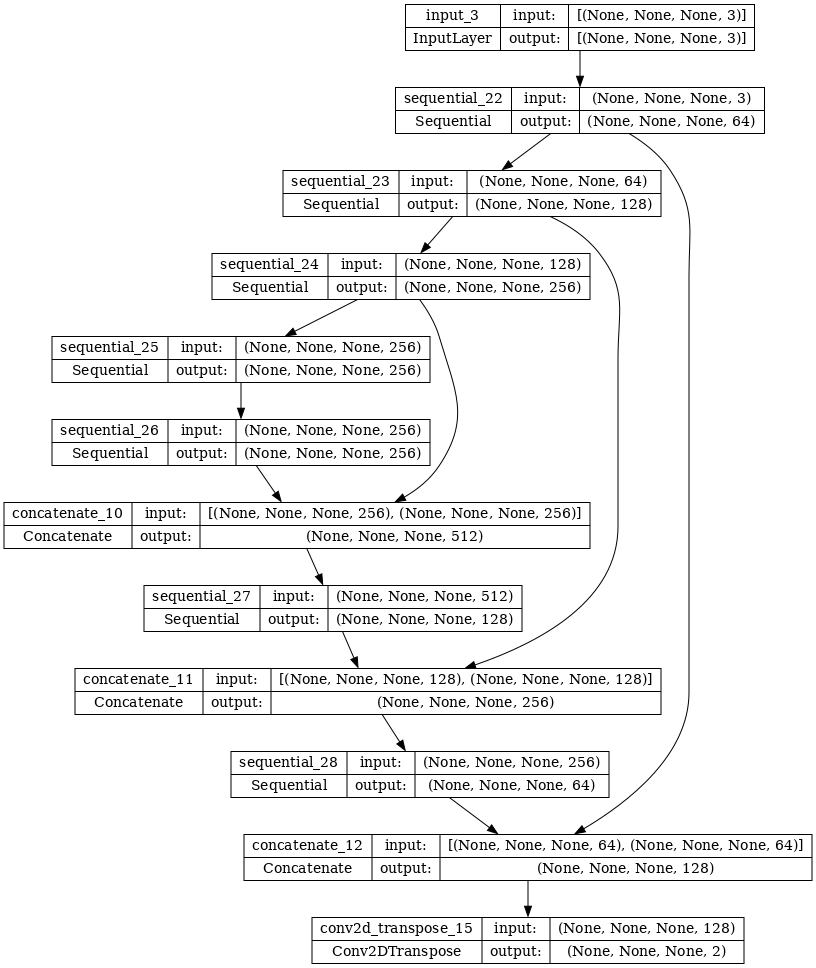

In [ ]:
input_layer = tf.keras.layers.Input(shape=(None, None) + (3,))
x1 = down_sampling_block(64, batch_nom=False)(input_layer)
x2 = down_sampling_block(128)(x1)
x3 = down_sampling_block(256)(x2)
x4 = down_sampling_block(256)(x3)
#x5 = down_sampling_block(256)(x4)
#x6 = down_sampling_block(256)(x5)
#x7 = down_sampling_block(256)(x6)

#y1 = up_sampling_block(256, dropout=True)(x7)
#y_conc1 = tf.keras.layers.Concatenate()([y1, x6])
#y2 = up_sampling_block(256, dropout=True)(x6)
#y_conc2 = tf.keras.layers.Concatenate()([y2, x5])
#y3 = up_sampling_block(256, dropout=True)(y_conc2)
#y_conc3 = tf.keras.layers.Concatenate()([y3, x4])
y4 = up_sampling_block(256)(x4)
y_conc4 = tf.keras.layers.Concatenate()([y4, x3])
y5 = up_sampling_block(128)(y_conc4)
y_conc5 = tf.keras.layers.Concatenate()([y5, x2])
y6 = up_sampling_block(64)(y_conc5)
y_conc6 = tf.keras.layers.Concatenate()([y6, x1])

output_layer = tf.keras.layers.Conv2DTranspose(CLASSES, kernel_size=3, strides=2, padding='same', activation='sigmoid')(y_conc6)

unet_like = tf.keras.Model(inputs=input_layer, outputs=output_layer)

print(unet_like.summary())
tf.keras.utils.plot_model(unet_like, show_shapes=True, dpi=72)


# Генераторы

In [ ]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, data, labels, batch_size=32):
        self.batch_size = batch_size
        self.data = data
        self.labels = labels

    def __len__(self):
        return int(np.round(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        X_path = self.data[index * self.batch_size : (index + 1) * self.batch_size]
        X = []
        for i in range(self.batch_size):
            x = tf.io.read_file(X_path[i])
            x = tf.io.decode_png(x)
            x = tf.image.resize(x, SAMPLE_SIZE)
            X.append(x)
        X = np.array(X)
        X = X / 255.

        #X = cv2.resize(X, dsize=(256, 384), interpolation=cv2.INTER_NEAREST)

        y_path = self.labels[index * self.batch_size : (index + 1) * self.batch_size]
        Y = []
        for i in range(self.batch_size):
            y = tf.io.read_file(y_path[i])
            y = tf.io.decode_png(y)
            y = tf.image.rgb_to_grayscale(y)
            y = tf.image.resize(y, SAMPLE_SIZE)
            Y.append(y)
        Y = np.array(Y)
        Y = Y / 255.
        #Y = cv2.resize(Y, dsize=(256, 384), interpolation=cv2.INTER_NEAREST)


        masks = []
        for i in range(CLASSES):
            copy = Y.copy()
            copy[np.where(Y == i)] = 1
            copy[np.where(Y != i)] = 0
            masks.append(copy)

        mask = np.stack(masks, axis=3)
        mask = np.squeeze(mask)
        #X = np.array([plt.imread(X[i], format='jpg') for i in range(len(X))])
        #y = np.array([plt.imread(y[i], format='gif') for i in range(len(y))])
        return sklearn.utils.shuffle(X, random_state=42), sklearn.utils.shuffle(mask, random_state=42)


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
images_train, images_val, masks_train, masks_val = train_test_split(images, masks, test_size=0.01, random_state=42)

In [ ]:
data_gen = DataGenerator(images_train[0:20], masks_train[0:20], 16)
data_gen_val = DataGenerator(images_val, masks_val, 8)

In [ ]:
import tensorflow.keras.backend as K

def dice_mc_metric(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return dice

def dice_mc_loss(a, b):
    return 1 - dice_mc_metric(a, b)

def dice_bce_mc_loss(a, b):
    return 0.3 * dice_mc_loss(a, b) + tf.keras.losses.binary_crossentropy(a, b)

In [ ]:
from keras import callbacks
model_checkpoint = callbacks.ModelCheckpoint(filepath='model_best_{epoch}.h5',
                                             monitor = 'val_dice_mc_metric',
                                             verbose=1,
                                             save_best_only=True,
                                             save_weights_only=False,
                                             mode='max')
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_dice_mc_metric',
                                        factor=0.1,
                                        patince=0,
                                        verbose=1,
                                        mode='min',
                                        min_delta=0,
                                        cooldown=0,
                                        min_lr=1e-10)

In [ ]:
unet_like.compile(optimizer='adam', loss=[dice_bce_mc_loss], metrics=[dice_mc_metric])

In [ ]:
history_dice = unet_like.fit(data_gen, validation_data = data_gen_val , epochs=10, callbacks=[reduce_lr ])


In [ ]:
plt.plot(history_dice.history['dice_mc_metric'], label='train_dice')
#plt.plot(history_dice.history['val_dice_mc_metric'], label='val_dice')
plt.show()

In [ ]:
unet_like.save_weights('/kaggle/working/networks/unet_like')

In [ ]:
!zip -r file.zip networks

In [ ]:
from IPython.display import FileLink
FileLink(r'file.zip')

In [ ]:
unet_like.load_weights('/kaggle/input/weights/networks/unet_like')

# SuperPixels

In [ ]:
import os
import os.path
from skimage import io

PATH = "/kaggle/input/test-dataset/scribble_supervise/ds0"

X_test = []
scrib_test = []

for i, file in enumerate(os.listdir(os.path.join(PATH, "img"))):
    #filename_wo_ext = file.with_suffix('')
    X_test.append(io.imread(os.path.join(PATH, "img", file)))
    scrib_test.append(io.imread(os.path.join(PATH, "masks_machine", os.path.splitext(file)[0] + '.png'), as_gray=True))

#for i, file in enumerate(os.listdir(os.path.join(PATH, "masks_machine"))):
#    scrib_test.append(io.imread(os.path.join(PATH, "masks_machine", file), as_gray=True))

In [ ]:
class SuperPixel(object):
    def __init__(self, cluster_index, pixels):
        self.pixels = pixels
        self.cluster_index = cluster_index
        self.neighbors_index = []
        self.color_histogram = None
        self.texture_histogram = None
        self.mark = -1

In [ ]:
from skimage.segmentation import slic
def get_super_pixels(img, count=200):
    super_pixels = dict()
    segments_slic = slic(img, n_segments=count, compactness=10, sigma=1, start_label=1)
    for index in np.unique(segments_slic):
        super_pixels[index] = (SuperPixel(index, np.where(segments_slic == index)))
    return segments_slic, super_pixels

In [ ]:
segments_slic, s = get_super_pixels(X_train[0])

In [ ]:
image = X_train[0].copy()
image[s[3].pixels] = 0

plt.imshow(image)

In [ ]:
np.unique(segments_slic)

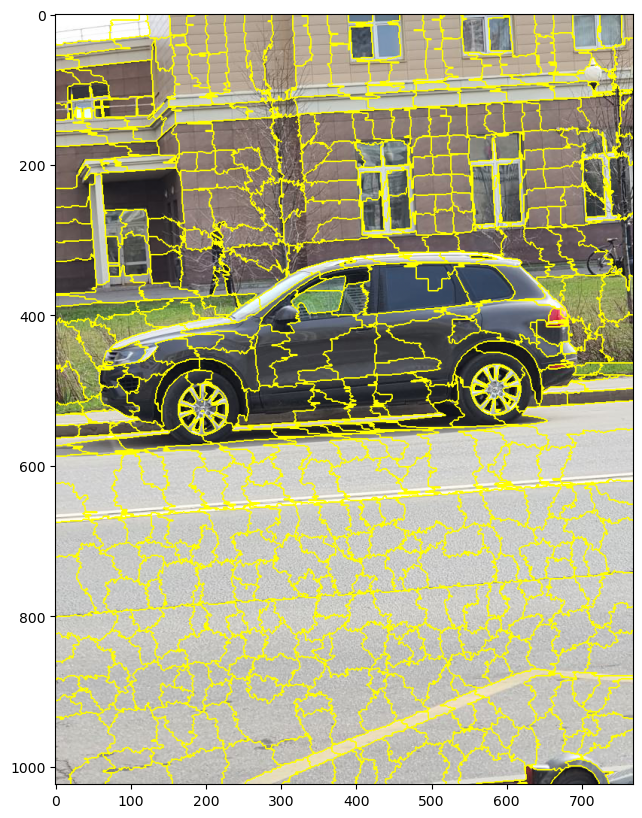

In [ ]:
from skimage.segmentation import mark_boundaries
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed

from skimage.filters import sobel
from skimage.color import rgb2gray
plt.figure(figsize=(10, 10))

segments_quick = quickshift(X_train[0], kernel_size=5, max_dist=15, ratio=0.5) + 1
plt.imshow(mark_boundaries(X_train[0], segments_quick))


# SuperPixels Similarity

In [ ]:
def normalize_histogram(histogram):
    bins = histogram.shape[0]
    wight = 1 / bins
    return histogram / (wight * np.sum(histogram))

In [ ]:
def make_color_histogram(image, bins_num=25):
    """
    mas = np.zeros(bins_num)
    img = image[..., 0]
    img = img // (255 / (bins_num - 1))
    for i in range(bins_num):
        mas[i] = np.sum(np.where(img == i, 1, 0))
    return mas
    """
    rez = np.array(0)
    hist = []
    for chanel in range(image.shape[-1]):
        hist.append(np.histogram(image[..., chanel].flatten(), bins=bins_num)[0])
    rez = np.concatenate(hist)
    return normalize_histogram(rez)

In [ ]:
from scipy.ndimage import convolve
import math
def gauss_function_derivative_x(x, y, sigma_d):
    return math.exp(-(x ** 2 + y ** 2) / (2 * sigma_d ** 2)) * (-x) / (2 * math.pi * sigma_d ** 4)

def gauss_function_derivative_y(x, y, sigma_d):
    return math.exp(-(x ** 2 + y ** 2) / (2 * sigma_d ** 2)) * (-y) / (2 * math.pi * sigma_d ** 4)
def make_gauss_matrix_derivative(gauss_function_derivative, sigma_d=1):
    size = 2 * 3 * int(sigma_d) + 1
    gauss_matrix = np.zeros((size, size), dtype=np.float64)
    for y in range(-size // 2, size // 2 + 1):
        for x in range(-size // 2, size // 2 + 1):
            value = gauss_function_derivative(x, y, sigma_d)
            gauss_matrix[size // 2 + y][size // 2 + x] = value
    return gauss_matrix

def find_gradient(image):
    grad_x = np.zeros(image.shape)
    grad_y = np.zeros(image.shape)
    gauss_matrix_derivative_x = np.array(make_gauss_matrix_derivative(gauss_function_derivative_x))
    gauss_matrix_derivative_y = np.array(make_gauss_matrix_derivative(gauss_function_derivative_y))
    for chanel in range(image.shape[-1]):
        grad_x[..., chanel] = convolve(image[..., chanel], gauss_matrix_derivative_x)
        grad_y[..., chanel] = convolve(image[..., chanel], gauss_matrix_derivative_y)
    return grad_x, grad_y

def make_texture_histogram(image, grad_x, grad_y, bins_num=10):
    hist = []
    for chanel in range(image.shape[-1]):
        hist.append(np.histogram(grad_x.flatten(), bins=bins_num)[0])
        hist.append(np.histogram(grad_y.flatten(), bins=bins_num)[0])
    rez = np.concatenate(hist)
    return normalize_histogram(rez)

# SuperPixels neighbors

In [ ]:
from skimage.segmentation import find_boundaries

In [ ]:
def find_neighbors(segments_slic, s):
    for cluster in s.values():
        tmp = np.where(segments_slic == cluster.cluster_index, 1, 0)
        boundaries = find_boundaries(tmp).astype(np.uint8)
        segments_boundaries = segments_slic * boundaries
        neighbors = np.unique(segments_boundaries)
        cluster.neighbors_index = np.delete(neighbors, np.where((neighbors == 0) | (neighbors == cluster.cluster_index)))

# GRAPH CUT

In [ ]:
!pip install PyMaxflow
import maxflow as mf


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 784.2/784.2 kB 19.7 MB/s eta 0:00:0000:01


In [ ]:
def find_intersection_with_scribble(segments_slic, scribble_sup, clusters):
    rez = dict()
    for label in np.unique(scribble_sup[np.where(scribble_sup != 0)]):
        mask = np.where(scribble_sup == label, 1, 0)
        superpixels_index = np.unique(segments_slic * mask)
        rez[label] = np.delete(superpixels_index, np.where(superpixels_index == 0))
        for index in rez[label]:
            clusters[index].mark = label
    return rez

In [ ]:
def like_func(cluster1, cluster2, delta_c=5, delta_t=10):
    if(cluster1.mark != cluster2.mark):
        return np.exp(-(np.linalg.norm(cluster1.color_histogram - cluster2.color_histogram, ord=2) ** 2 / delta_c ** 2 + np.linalg.norm(cluster1.texture_histogram - cluster2.texture_histogram, ord=2) ** 2 / delta_t ** 2))
    else: return 0

In [ ]:
def get_ground_truth(graph, nodes, s, image):
    ground_truth = np.zeros(image.shape[:2])
    for i in range(nodes.shape[0]):
        s[i + 1].mark = 2 if graph.get_segment(nodes[i]) == 0 else 1
        ground_truth[s[i + 1].pixels] = graph.get_segment(nodes[i])
    return ground_truth

In [ ]:
def make_st_graph(clasters):
    g = mf.Graph[float](len(clasters), 0)
    nodes = g.add_nodes(len(clasters))
    for cluster in clasters.values():
        for neighbor_index in cluster.neighbors_index:
            weight = like_func(cluster, clasters[neighbor_index])
            g.add_edge(nodes[cluster.cluster_index - 1], nodes[neighbor_index - 1], weight, weight)
        if cluster.mark == 1:
            weight_sourse = 0
            weight_sink = np.inf
        elif cluster.mark == 2:
            weight_sourse = np.inf
            weight_sink = 0
        else:
            weight_sourse = -np.log(1/2)
            weight_sink = -np.log(1/2)
        g.add_tedge(nodes[cluster.cluster_index - 1], weight_sourse, weight_sink)
    return g, nodes

In [ ]:
segments_slic = slic(X_test[ind], n_segments=200, compactness=10, sigma=1, start_label=1)

# Визуализация

In [ ]:
def visualization(image, mask, scribble):
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].set_title('Изображение с наложенной маской')
    ax[0].imshow(image)
    ax[0].imshow(mask, alpha=0.5)

    ax[1].set_title('scribble разметка')
    ax[1].imshow(scribble)


# Training

In [ ]:
import os
import os.path
from skimage import io

PATH = "/kaggle/input/dataset100/scribble_supervise_car/ds0_003"

SAMPLE_SIZE = (1024, 768)

X_train = []
scrib_train = []

for i, file in enumerate(os.listdir(os.path.join(PATH, "img"))):
    #filename_wo_ext = file.with_suffix('')
    X_train.append(io.imread(os.path.join(PATH, "img", file)))
    scrib_train.append(io.imread(os.path.join(PATH, "masks_machine", os.path.splitext(file)[0] + '.png'), as_gray=True))

#for i, file in enumerate(os.listdir(os.path.join(PATH, "masks_machine"))):
#    scrib_test.append(io.imread(os.path.join(PATH, "masks_machine", file), as_gray=True))

In [ ]:
def preprocessing(dataset, scribbles):
    superpixels = []
    for image, scribble in zip(dataset, scribbles):
        segments_slic, clusters = get_super_pixels(image, count=200)
        grad_x, grad_y = find_gradient(image)
        for cluster in clusters.values():
            cluster.color_histogram = make_color_histogram(image[cluster.pixels])
            cluster.texture_histogram = make_texture_histogram(image, grad_x[cluster.pixels], grad_y[cluster.pixels])
        find_neighbors(segments_slic, clusters)
        sp_ind = find_intersection_with_scribble(segments_slic, scribble, clusters)
        dublicates = np.intersect1d(sp_ind[1], sp_ind[2])
        for index in dublicates:
            clusters[index].mark = -1
        sp_ind[1] = np.delete(sp_ind[1], np.where(np.in1d(sp_ind[1], dublicates)))
        sp_ind[2] = np.delete(sp_ind[2], np.where(np.in1d(sp_ind[2], dublicates)))
        superpixels.append(clusters)
        #print('done')
    return superpixels

In [ ]:
superpixels = preprocessing(X_train, scrib_train)

In [ ]:
def get_ground_truth(graph, nodes, s, image):
    ground_truth = np.zeros((image.shape[0:2] + (2,)))
    for j, i in enumerate(range(nodes.shape[0])):
        #print(j+1, graph.get_segment(nodes[i]))
        ground_truth[..., 0][s[i + 1].pixels] = 1 if graph.get_segment(nodes[i]) == 0 else 0
        ground_truth[..., 1][s[i + 1].pixels] = graph.get_segment(nodes[i])
    return ground_truth

In [ ]:
def like_func(claster1, claster2, delta_c=25, delta_t=10):
    return np.exp(-(np.linalg.norm(claster1.color_histogram - claster2.color_histogram, ord=2) ** 2 / delta_c ** 2 + np.linalg.norm(claster1.texture_histogram - claster2.texture_histogram, ord=2) ** 2 / delta_t ** 2))

In [ ]:
def log_superpixel(image, cluster):
    back_superpixel = image[0, ..., 0][cluster.pixels]
    car_superpixel = image[0, ..., 1][cluster.pixels]
    return -np.sum(np.where(back_superpixel != 0, np.log(back_superpixel), -50)), -np.sum(np.where(car_superpixel != 0, np.log(car_superpixel), -50))

In [ ]:
def get_mask_with_net(image, clusters, network):
    graph = mf.Graph[float](len(clusters), 0)
    nodes = graph.add_nodes(len(clusters))
    prediction = network.predict(np.expand_dims(image / 255, axis=0))
    for cluster in clusters.values():
        for neighbor_index in cluster.neighbors_index:
            weight = like_func(cluster, clusters[neighbor_index])
            graph.add_edge(nodes[cluster.cluster_index - 1], nodes[neighbor_index - 1], weight, weight)
        log = log_superpixel(prediction, cluster)
        log_car = log[1]
        log_back = log[0]
        if cluster.mark == 1:
            weight_sourse = np.inf + log_car
            weight_sink = 0 + log_back
        elif cluster.mark == 2:
            weight_sourse = 0 + log_car
            weight_sink = np.inf + log_back
        else:
            weight_sourse = -np.log(1/2) + log_car
            weight_sink = -np.log(1/2) + log_back
        graph.add_tedge(nodes[cluster.cluster_index - 1], weight_sourse, weight_sink)
    graph.maxflow()
    return get_ground_truth(graph, nodes, clusters, image)

In [ ]:
def get_mask_without_net(image, clusters):
    graph = mf.Graph[float](len(clusters), 0)
    nodes = graph.add_nodes(len(clusters))
    for cluster in clusters.values():
        for neighbor_index in cluster.neighbors_index:
            weight = like_func(cluster, clusters[neighbor_index])
            graph.add_edge(nodes[cluster.cluster_index - 1], nodes[neighbor_index - 1], weight, weight)
        if cluster.mark == 1:
            weight_sourse = np.inf
            weight_sink = 0
        elif cluster.mark == 2:
            weight_sourse = 0
            weight_sink = np.inf
        else:
            weight_sourse = -np.log(1/2)
            weight_sink = -np.log(1/2)
        graph.add_tedge(nodes[cluster.cluster_index - 1], weight_sourse, weight_sink)
    graph.maxflow()
    return get_ground_truth(graph, nodes, clusters, image)


In [ ]:
def get_masks(dataset, superpixels, network=None):
    masks = []
    for image, clusters in zip(dataset, superpixels):
        if network == None:
            masks.append(get_mask_without_net(image, clusters))
        else:
            masks.append(get_mask_with_net(image, clusters, unet_like))
    return masks

In [ ]:
def visualization(image, mask, scribble):
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].set_title('Изображение с наложенной маской')
    ax[0].imshow(image)
    ax[0].imshow(mask, alpha=0.5)

    ax[1].set_title('scribble разметка')
    ax[1].imshow(scribble)

In [ ]:
masks = get_masks(X_train, superpixels)

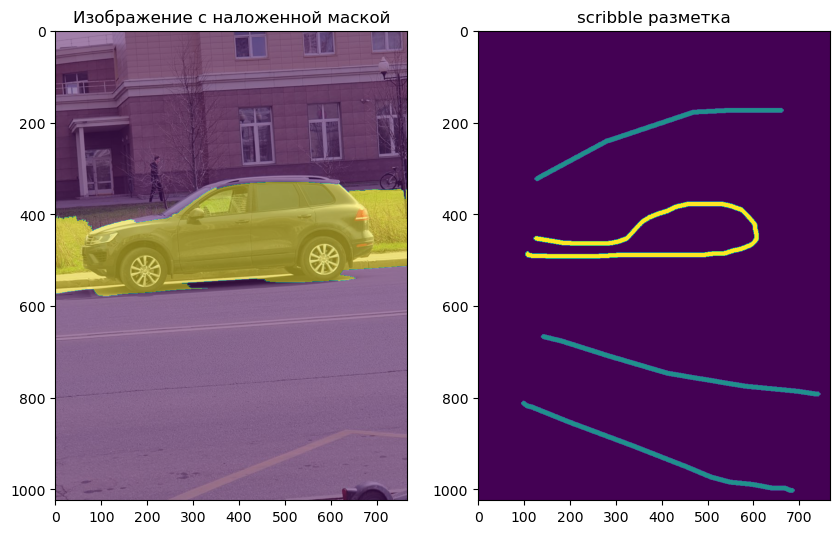

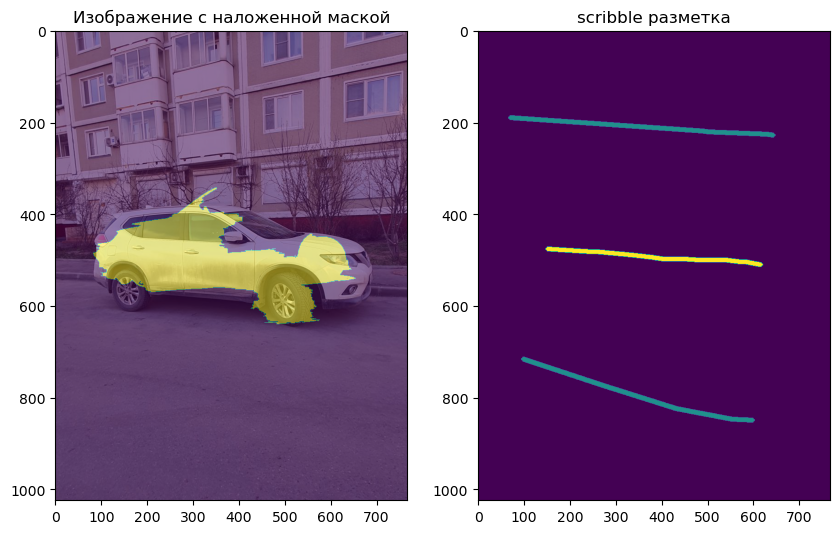

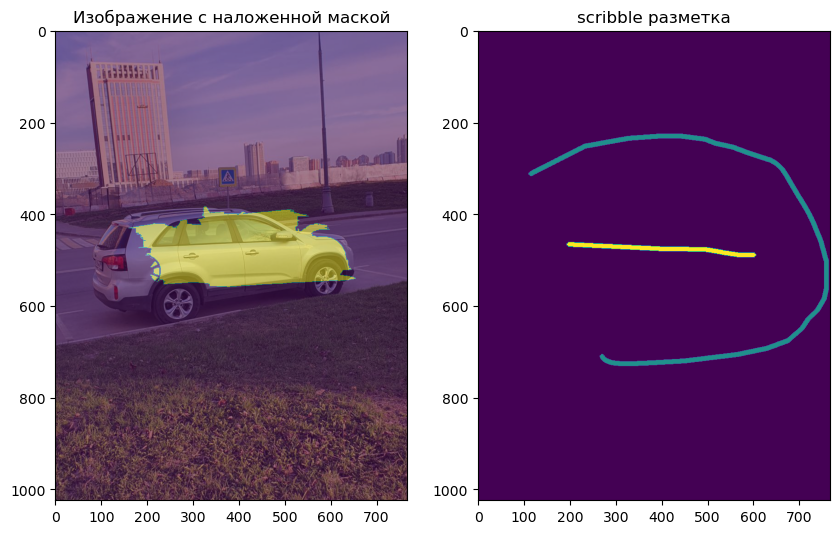

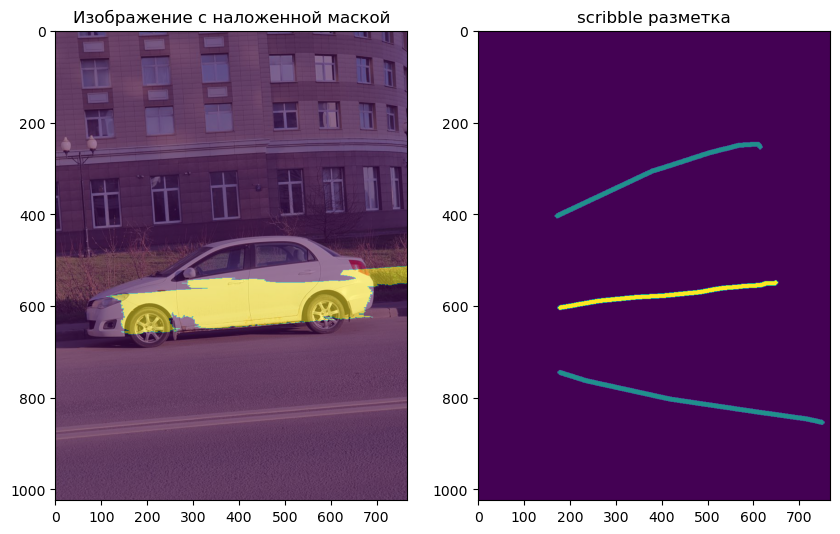

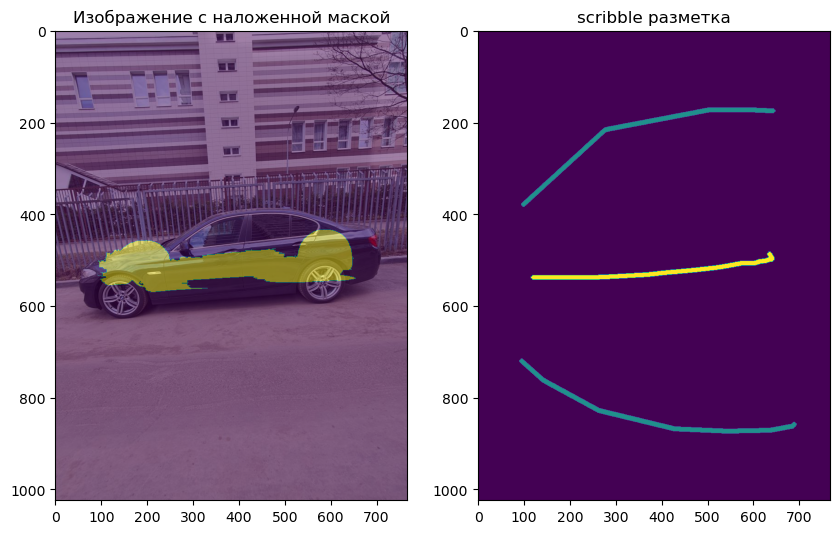

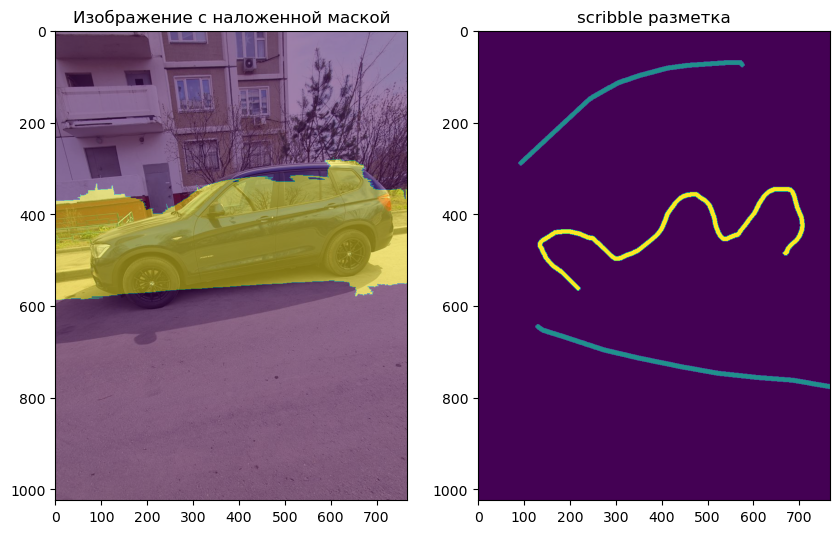

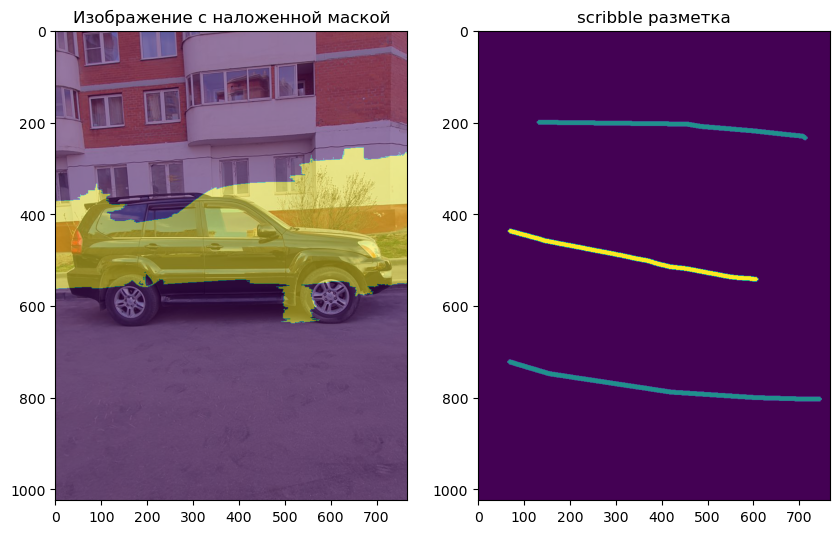

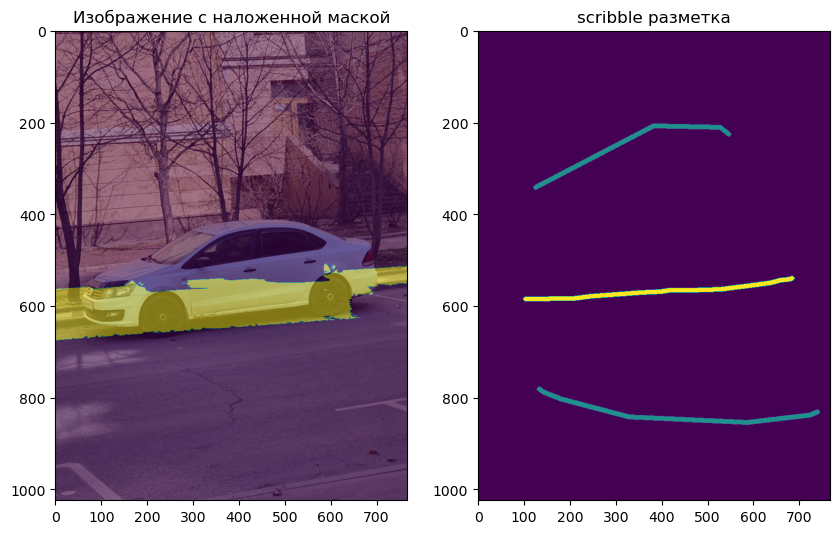

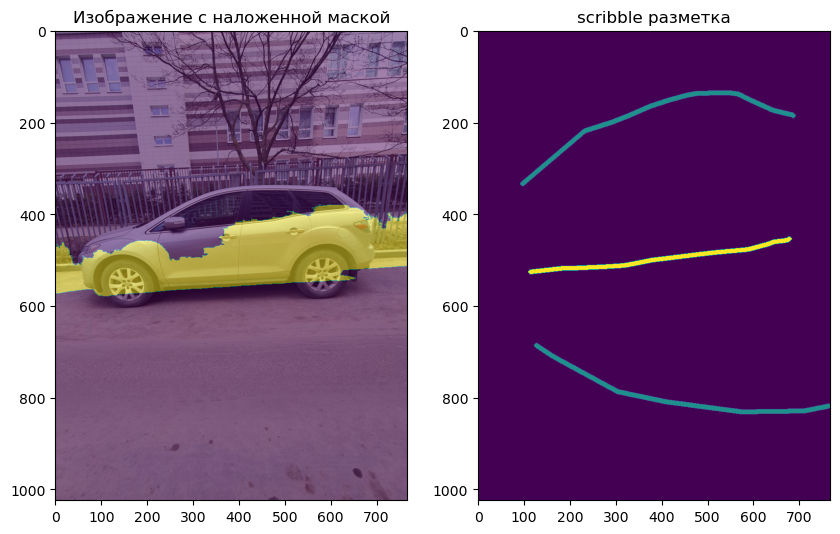

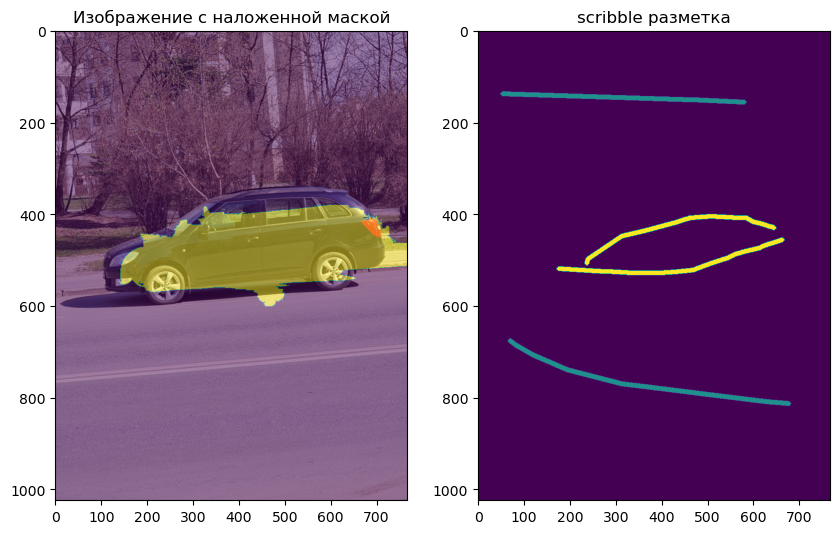

In [ ]:
for image, ground_truth, scrib in zip(X_train[0:10], masks[0:10], scrib_train[0:10]):
    visualization(image, ground_truth[..., 1], scrib)

# Дообучение


In [ ]:
import os
import os.path
from skimage import io

PATH = "/kaggle/input/gtruth/ground_truth/ds0"

SAMPLE_SIZE = (1024, 768)

X_test = []
ground_truth = []
for i, file in enumerate(os.listdir(os.path.join(PATH, "img"))):
    #filename_wo_ext = file.with_suffix('')
    X_test.append(io.imread(os.path.join(PATH, 'img', file)))
    ground_truth.append(io.imread(os.path.join(PATH, "masks_machine", os.path.splitext(file)[0] + '.png'), as_gray=True))
#for i, file in enumerate(os.listdir(os.path.join(PATH, "masks_machine"))):
#    scrib_test.append(io.imread(os.path.join(PATH, "masks_machine", file), as_gray=True))

In [ ]:
true_masks = []
for i in range(CLASSES):
    i = CLASSES - i
    ground_truth = np.array(ground_truth)
    copy = ground_truth.copy()
    copy[np.where(ground_truth == i)] = 1
    copy[np.where(ground_truth != i)] = 0
    true_masks.append(copy)

true_masks = np.stack(true_masks, axis=3)
true_masks = np.squeeze(true_masks)

In [ ]:
unet_like.load_weights('/kaggle/input/weights/networks/unet_like')

In [ ]:
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3]) + K.sum(y_pred,[1,2,3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return dice

In [ ]:
def compute_dice_IOU(X_test, true_masks, network):
    predictions = network.predict(X_test / 255)
    iou = iou_coef(true_masks.astype(np.float32), predictions)
    dice = dice_coef(true_masks.astype(np.float32), predictions)
    #for prediction, true_mask in zip(predictions, true_masks.astype(np.float32)):
    #    dise.append(dice_coef(true_mask, prediction))
    #    iou.append(iou_coef(true_mask, prediction))
    return dice, iou

In [ ]:
from keras import backend as K

def iterations(X, superpixels, X_test, true_masks, network, iter_amount=3):
    dice, iou = compute_dice_IOU(X_test, true_masks, network)
    print(f'start: dice = {dice}, IOU = {iou}')

    for iteration in range(iter_amount):
        K.set_value(network.optimizer.learning_rate, 0.0001)
        if iteration == 0:

            masks = get_masks(X, superpixels, None)
            data_generator = DataGenerator(X, masks, batch_size=5)
            history_dice = network.fit(data_generator, epochs=1)

        else:

            masks = get_masks(X, superpixels, network)
            data_generator = DataGenerator(X, masks, batch_size=5)
            val_generator = DataGenerator(X_test, true_masks, batch_size=5)
            history_dice = network.fit(data_generator, epochs=1)

        for image in X_test:
            prediction = unet_like.predict(np.expand_dims(image / 255, axis=0))
            fig, ax = plt.subplots(1, 2, figsize=(10, 10))
            ax[0].set_title('Изображение')
            ax[0].imshow(image)

            ax[1].set_title('Предсказанная маска')
            ax[1].imshow(prediction[0, ..., 1])
            plt.show()

        dice, iou = compute_dice_IOU(X_test, true_masks, network)
        print(f'iteration {iteration}: dice = {dice}, IOU = {iou}')

In [ ]:
iterations(X_train, superpixels, X_test, true_masks, unet_like, iter_amount=3)